# Gaussianization Flows

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(here()))
except ModuleNotFoundError:
    %%capture
    import os
    os.system("pip install objax wandb chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as np
from jax.config import config
# import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial
import objax
import chex

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss
from rbig_jax.transforms.mixture import MixtureGaussianCDF
from rbig_jax.transforms.logit import Logit
from rbig_jax.transforms.inversecdf import InverseGaussCDF
from rbig_jax.transforms.linear import HouseHolder
from rbig_jax.transforms.base import CompositeTransform
from rbig_jax.models.gaussflow import GaussianizationFlow


# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Demo Data

<Figure size 432x288 with 0 Axes>

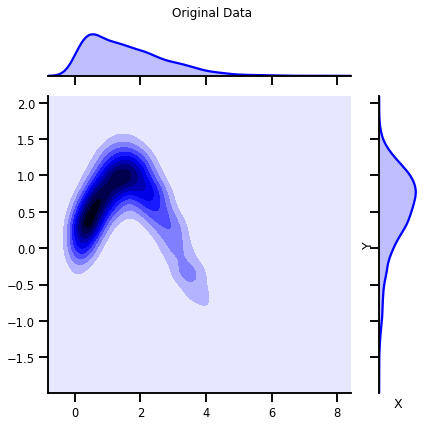

In [3]:
# %%wandb
# get data

n_samples = 2_000
n_features = 2


data = get_classic(n_samples)

# plot data
plot_joint(data, "blue", "Original Data", kind='kde', logger=False)

### Model

In [4]:
# model hyperparameters
n_components = 20
n_reflections = 2
generator = objax.random.Generator(123)
learn_temperature = False
n_features = data.shape[1]

# initialize model
bijections = CompositeTransform([
    # Layer I
    MixtureGaussianCDF(n_features=n_features, n_components=n_components),
    Logit(learn_temperature=learn_temperature),
    HouseHolder(n_features=n_features, n_reflections=n_reflections, generator=generator),
    # Layer II
    MixtureGaussianCDF(n_features=n_features, n_components=n_components),
    Logit(learn_temperature=learn_temperature),
    HouseHolder(n_features=n_features, n_reflections=n_reflections, generator=generator),
    # Layer III
    MixtureGaussianCDF(n_features=n_features, n_components=n_components),
    Logit(learn_temperature=learn_temperature),
    HouseHolder(n_features=n_features, n_reflections=n_reflections, generator=generator),
    # Layer IV
    MixtureGaussianCDF(n_features=n_features, n_components=n_components),
    Logit(learn_temperature=learn_temperature),
    HouseHolder(n_features=n_features, n_reflections=n_reflections, generator=generator),
])

# initialize base distribution
base_dist = jax.scipy.stats.norm

# initialize Model
gf_model = GaussianizationFlow(n_features=n_features, bijections=bijections, base_dist=base_dist)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [5]:
from pprint import pprint

# pprint(gf_model.vars())

#### Loss Function

In [6]:
# vectorized the model to allow for batches
# model_vectorized = objax.Vectorize(model, vc=model.vars())

# model_jitted = objax.Jit(model, vc=model.vars())


@objax.Function.with_vars(gf_model.vars())
def nll_loss(x):
    return gf_model.score(x)

In [7]:
nll_loss(data)

DeviceArray(59.34306, dtype=float32)

##### Optimizer

In [8]:
# define the optimizer
opt = objax.optimizer.Adam(gf_model.vars())

# get grad values
gv = objax.GradValues(nll_loss, gf_model.vars())
lr = 0.01
epochs = 500
batch_size = 128

@objax.Function.with_vars(gf_model.vars() + opt.vars())
def train_op(x):
    g, v = gv(x)  # returns gradients, loss
    opt(lr, g)
    return v

# This line is optional: it is compiling the code to make it faster.
train_op = objax.Jit(train_op)

#### Testing

In [9]:
import itertools
from jax import device_put
import tqdm
from jax import random


# initialize parameters
key = random.PRNGKey(123)
itercount = itertools.count()
permute_rng, rng = random.split(key)

train_data = np.array(data)

losses = list()

pbar = tqdm.trange(epochs)

with pbar:
    for i in pbar:

        # batch processing
        permute_rng, rng = random.split(rng)

        # randomly shuffle the data
        train_data = random.permutation(permute_rng, train_data)

        # Train
        avg_loss = []

        for batch_index in range(0, n_samples, batch_size):
            # compute loss
            loss = float(train_op( train_data[batch_index:batch_index+batch_size])[0])
            # append batch
            avg_loss.append(loss)
        # average loss
        batch_loss = np.mean(np.stack(avg_loss))

        # Log losses
        losses.append(batch_loss)
        pbar.set_postfix({"loss": f"{batch_loss:.4f}"})

100%|██████████| 500/500 [01:07<00:00,  7.39it/s, loss=1.4317] 


#### Losses

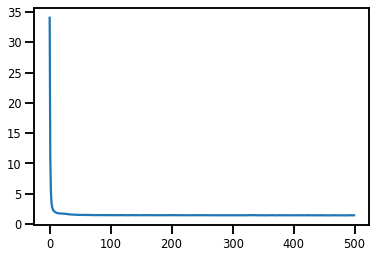

In [10]:
plt.plot(losses)

#### Forward Transformation

In [11]:
# forward transformation
z = gf_model.transform(np.array(data))

<Figure size 432x288 with 0 Axes>

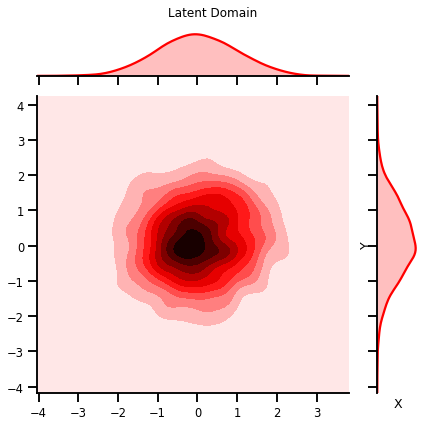

In [12]:
plot_joint(onp.array(z), "red", "Latent Domain", kind='kde', logger=False)

#### Inverse Transformation

In [13]:
# forward transformation
x_approx = gf_model.inverse_transform(z)

<Figure size 432x288 with 0 Axes>

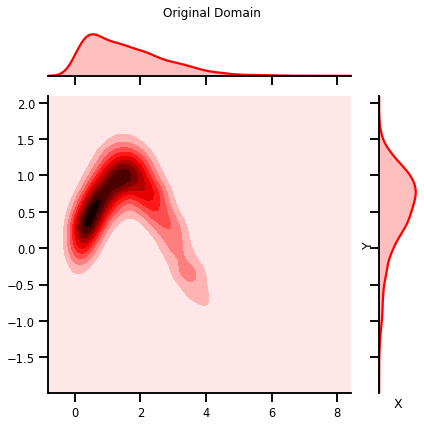

In [14]:
plot_joint(onp.array(x_approx), "red", "Original Domain", kind='kde', logger=False)

### Application I - Generating Samples

In [15]:
%%time
# generate samples in the latent domain
n_gen_samples = 2_000

# inverse transformation
x_samples = gf_model.sample(n_gen_samples)

CPU times: user 34.2 s, sys: 2.1 s, total: 36.3 s
Wall time: 8.55 s


<Figure size 432x288 with 0 Axes>

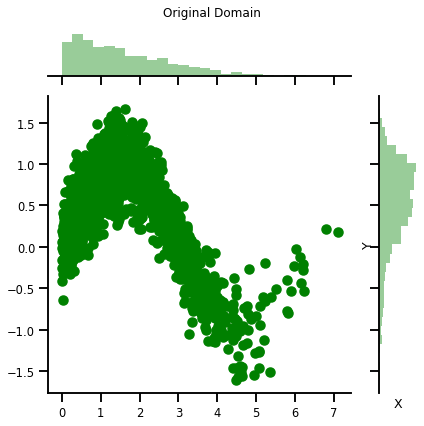

In [16]:
plot_joint(onp.array(x_samples), "green", "Original Domain", kind='scatter', logger=False)

### Probability Density Estimation

In [17]:
%%time
# log probability
log_prob = gf_model.score_samples(np.array(data))

CPU times: user 559 ms, sys: 36.2 ms, total: 595 ms
Wall time: 446 ms


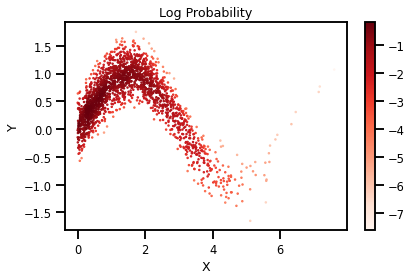

In [18]:
cmap = "Reds"
probs = np.array(log_prob)
# probs = np.clip(probs, 0.0, 1.0)
title = "Log Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=log_prob,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

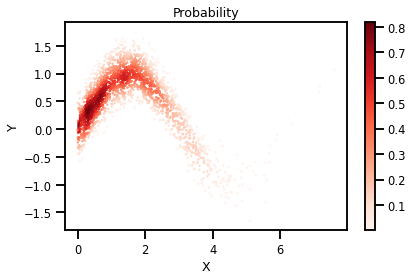

In [19]:
cmap = "Reds"
probs = np.exp(np.array(log_prob))
# probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()